# Assignment 2: Feature Engineering & Linear Regression
Olivia Steed
301421820

## **Introduction**

In this assignment, you will focus on **feature engineering** and **linear regression**.

The dataset is collected from an e-commerce platform (https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset)
and includes records of user interactions with products, as well as item metadata. The main table you'll work with is the **`events`** table. It logs the **timestamp**, **user ID**, **item ID**, the type of event (`view`, `add_to_cart`, or `transaction`), and, for purchases, a **transaction ID**.

There is also an **item properties** table, which contains two main pieces of information: whether an item is **available** (denoted as 0 or 1), and a **category ID**. However, the meaning of the timestamp in this table is unclear — it could indicate when the category was assigned or when a change occurred. Additionally, a **category tree** table defines parent-child relationships between categories. Note that a category may have a parent, and that parent may have its own parent, forming a hierarchy.

---

#### Additional Notes

- If the dataset is too large to process on your machine, you may **subset the data** — for example, by limiting the number of users or items.
- You may also choose to **exclude item-weeks where no purchases occurred** (i.e., weekly purchase count is zero).
- If you face any errors while converting timestamp values to date/time (if needed), try dividing the values by **1000** — this converts them from **milliseconds to seconds**.

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Restructuring the dataset
Your first task is to **restructure the dataset** to calculate the number of times each item was **successfully purchased per week**. This weekly sales count will be the **target variable** in your regression model.

First I'm going to get familiar with each dataset's contents and how they relate to each other.

In [3]:
# Load the dataset and get familiar with the event types and metadata

event_df = pd.read_csv("a2_dataset/events.csv")
item_df = pd.read_csv("a2_dataset/item_properties.csv")
category_df = pd.read_csv("a2_dataset/category_tree.csv")

**event_df** is log data from each event by timestamp including timestamp, visitorid, event type, itemid, transactionid. This can be used to get the amount of purchases per product per week by visitor, and view general visitor visiting, adding to card, and transaction behaviour. The dataset is mainly integers and floats, with objects for the event type, but this could be one-hot encoded if needed. 

In [4]:
# event_df is log data from each event by timestamp

event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [5]:
event_df.head(10)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
5,1433224086234,972639,view,22556,NaN
6,1433221923240,810725,view,443030,NaN
7,1433223291897,794181,view,439202,NaN
8,1433220899221,824915,view,428805,NaN
9,1433221204592,339335,view,82389,NaN


**item_df** is the availability and category of each item by timestamp. The timestamp meaning is uncertain so I will just be using the availability and category values. The values are mainly integers and floats except for the property value which indicates if the value column corresponds to the categoryid (kind of product) or the availability (0 = not available, 1 = available). This dataset can be liked with events_df by itemid.

In [6]:
# item_df is the availability and category of each item by timestamp. 
item_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291930 entries, 0 to 2291929
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   itemid     int64  
 2   property   object 
 3   value      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 69.9+ MB


In [7]:
item_df.head(10)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338.0
1,1436065200000,285026,available,0.0
2,1437274800000,186518,available,0.0
3,1433646000000,423682,available,0.0
4,1434250800000,316253,available,1.0
5,1437274800000,430459,available,0.0
6,1433041200000,411262,available,0.0
7,1441508400000,50372,available,0.0
8,1441508400000,289043,available,0.0
9,1435460400000,365407,available,0.0


**category_df** includes parent-child relationships between categories, and links a record's categoryid with the parent's categoryid. This could be connected to item_df by categoryid. It contains integer and float ids so will be easy to work with numerically.

In [8]:
# category_df includes parent-child relationships between categories and can be linked with parentid to categoryid (?)
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [9]:
category_df.head(10)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
5,231,NaN
6,542,378.0
7,1146,542.0
8,1140,542.0
9,1479,1537.0


Now that I understand what the datasets contain and how they connect, I'm going to restructure the data to calculate the number of times each item was successfully puchased per week as the **weekly_sales_count** value. This is indicated by transactions in the event_df table, and will be used for the regression analysis to see what raw and engineered features correlate with this value.

In [10]:
# restructure dataset to calculate the number of times each item was successfully purchased per week (transaction event)

#START[ChatGPT 4.o] "i want to restructure a dataset to get the amount of successful purchases per item per week. here is my code now but it has this error, what am i doing wrong?
# error: TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
# code: weekly_sales_count = event_df[event_df['event'] == 'purchase'].groupby(['itemid', pd.Grouper(key='timestamp', freq='W')]).size().reset_index(name='sales_count')"
event_df['timestamp'] = pd.to_datetime(event_df['timestamp'], unit='ms')   # changing timestamp column to datetime format with milliseconds unit, otherwise all the dates will be the same
#END[ChatGPT 4.o]

# target variable for regression model
weekly_sales_count = event_df[event_df['event'] == 'transaction'].groupby(['itemid', pd.Grouper(key='timestamp', freq='W')]).size().reset_index(name='sales_count')

# check out our results
print(weekly_sales_count.head(50))


    itemid  timestamp  sales_count
0       15 2015-07-12            1
1       19 2015-08-16            1
2       25 2015-06-14            1
3       25 2015-08-09            1
4       42 2015-08-16            1
5      147 2015-09-06            4
6      168 2015-09-20            1
7      199 2015-07-19            1
8      212 2015-06-21            1
9      233 2015-06-21            1
10     304 2015-09-20            1
11     320 2015-06-21            1
12     387 2015-08-09            1
13     403 2015-06-14            1
14     496 2015-06-14            1
15     496 2015-06-21            1
16     546 2015-07-26            3
17     546 2015-08-02            5
18     546 2015-08-09            2
19     546 2015-08-16            2
20     546 2015-08-23            9
21     546 2015-08-30            2
22     563 2015-07-26            1
23     572 2015-06-21            1
24     651 2015-06-07            1
25     655 2015-08-02            1
26     698 2015-09-13            1
27     720 2015-08-2

## 2. Engineering features
Your second task is to **engineer features** from the dataset that may help predict weekly sales. You are required to create features from the following categories:

### Temporal Features (choose at least 2)

- `day_of_week`: Day when events occurred (1 = Monday, ..., 7 = Sunday)
- `week_of_month`: Week number within the calendar month
- `weeks_after_availability`: Weeks since the item became available
- `time_of_day_view/add`: Counts of views/adds during morning, afternoon, or night

#### days of the week one hot encoding

First I will one-hot encode the days of the week because I am interested in when people are online shopping the most. I would assume that it is less during the week when most people are at work, and more on weekends, however online shopping is possible to do from anywhere so people could be shopping at work as well. 

In [11]:
# encode days of the week in copy of event_df

#START[ChatGPT 4.o] "i have a dataset with timestamps in this format: 1970-01-01 00:23:53.197648801 how would i one hot encode these so there are columns for each day of the week with a 1 if it is that day and 0 if not? here is my code so far:
# event_df_copy = event_df.copy()
# event_df_copy['day_of_week'] = event_df_copy['timestamp'].dt.day_name()
# event_df_copy = pd.get_dummies(event_df_copy, columns=['day_of_week'], drop_first=True)"
# one hot encoding version
# event_df_copy = event_df.copy() # don't need to convert to timestamp again since we already did it above
# event_df_copy['day_of_week'] = event_df_copy['timestamp'].dt.day_name() # get day of the week from timestamp
# event_df_copy = pd.get_dummies(event_df_copy, columns=['day_of_week'], drop_first=False) #one-hot encode days of week
# END[ChatGPT 4.o]

event_df_copy = event_df.copy() # don't need to convert to timestamp again since we already did it above
# START[ChatGPT 4.o] "can i change this from one hot encoding to have a day of the week column with 1 for monday to 7 for sunday?"
event_df_copy['day_of_week'] = event_df_copy['timestamp'].dt.weekday + 1 # days numbered 1-7, where 1 is monday and 7 is sunday
# END[ChatGPT 4.o]

event_df_copy.head(10)

,timestamp,visitorid,event,itemid,transactionid,day_of_week
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2
5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2
6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2
7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2
8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2
9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2


#### timeframe of event

To compliment the days of the week feature, I want to look into the time of day people are most actively online shopping which would be demonstrated by their views and adds to cart. This will help fill in the picture of when people are shopping the most. Comparing the views and adds to cart with the actual transactions per week will give an indication as to when people are window-shopping for entertainment or to kill time, and when they are following through on making purchases.

In [12]:
# get counts of views and adds per item per time period
# morning is 6am-12pm, afternoon is 12pm-6pm, night is 12am-6am - four even time periods of 6 hours each

# START[ChatGPT 4.o] "i have a dataset with a log of ecommerce data. i want to get counts of views and adds per item per time period. there is a timestamp column and an event column with values view, addtocart, transaction. for time periods, morning is 6am-12pm, afternoon is 12pm-6pm, night is 6pm-6am. my dataframe in python is called events_df_copy. how would i do this?"

def get_time_period(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

event_df_copy['hour'] = event_df_copy['timestamp'].dt.hour # makes hour column of time hours in 24 hr format
event_df_copy['time_of_day'] = event_df_copy['hour'].apply(get_time_period) # categorizes hour into time of day (morning, afternoon, night)

# only look at view and addtocart events
views_df = event_df_copy[event_df_copy['event'] == 'view']
adds_df = event_df_copy[event_df_copy['event'] == 'addtocart']

# Table of view counts per item per time of day
view_counts = views_df.groupby(['itemid', 'time_of_day']).size().unstack(fill_value=0)

# Table of addtocart counts per item per time of day
add_counts = adds_df.groupby(['itemid', 'time_of_day']).size().unstack(fill_value=0)

# END[ChatGPT 4.o]

event_df_copy.head(10)

,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour,time_of_day
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2,5,night
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2,5,night
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2,5,night
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2,5,night
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2,5,night
5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2,5,night
6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2,5,night
7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2,5,night
8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2,4,night
9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2,5,night


In the above code I added labels for time of day with morning as 5am-12pm, afternoon as 12pm-7pm, and night as 7pm-5am. This allows me to see the afternoon, morning, and night activity for views and addtocarts per item in the newly created dataframes. I can also just aggregate them from the event_df_copy dataframe using the time_of_day or hour column.

In [ ]:
event_counts = (
    event_df_copy
    .groupby(['time_of_day', 'event'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(10, 6))
sns.barplot(data=event_counts, x='time_of_day', y='count', hue='event')

plt.title('Event Type Counts by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Event Count')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

In [13]:
view_counts.head(10)

time_of_day,afternoon,evening,morning,night
itemid,,,,
3,1,1,0,0
4,0,2,1,0
6,8,11,2,8
9,0,1,0,1
15,4,11,1,2
16,5,4,1,5
17,2,1,0,0
19,5,6,0,5
22,2,0,0,0


In [14]:
view_counts.describe()

time_of_day,afternoon,evening,morning,night
count,234838.000000,234838.000000,234838.000000,234838.000000
mean,2.611085,4.397184,0.831786,3.505263
std,8.391096,13.870214,2.772180,11.556773
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000
75%,2.000000,3.000000,1.000000,3.000000
max,852.000000,1267.000000,250.000000,1293.000000


This quick analysis shows us that on average, the most views per product are happening at night, as the mean is highest by far with 4.39 in the evening, compared to 0.83 views per product in the morning, 2.61 views per product in the afternoon, and 3.50 views per product at night. Let's check how this relates to the addtocart counts.

In [15]:
add_counts.head(10)

time_of_day,afternoon,evening,morning,night
itemid,,,,
15,0,3,0,0
19,0,1,0,0
25,0,1,1,2
33,0,3,0,0
42,0,1,0,1
66,1,0,0,0
102,0,1,0,0
147,4,0,0,1
168,0,0,0,1


In [16]:
add_counts.describe()

time_of_day,afternoon,evening,morning,night
count,23903.000000,23903.000000,23903.000000,23903.000000
mean,0.678199,1.205832,0.186797,0.829728
std,1.434170,2.344176,0.598682,1.684775
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000
max,65.000000,119.000000,31.000000,91.000000


The quick analysis of the addtocart counts also shows that on average, most addtocarts per product is happening in the evening, but the amount is much less, with only 1.20 add to carts per product at night compared to 0.18 add to carts per product in the morning, 0.67 add to carts per product in the afternoon, and 0.29 add to carts per product at night. It appears that the time between getting home from work and sleeping is the most popular for online shopping and purchasing, but we can look deeper into this later.

### Statistical Aggregates (choose at least 2) 

- `num_of_views`, `num_of_add_to_carts`: Total count for the week
- `mean`, `std` of views/add_to_carts: Across past weeks (moving average or full history)
- `monthly_avg_views/add_to_carts`: Long-term engagement trends

#### weekly total view, addtocart, transaction (by week)

In [17]:
# make new table with event_df_copy data with addtocart, transaction, view counts grouped by week

weekly_event_df = event_df_copy.copy()

# START [ChatGPT 4.o] "i want to take the dataset i have now which is log data every few minutes and aggregate the values into a row for each week of data. how would i do that?"
# timestamp will be week ending date
# weekly_event_df = (
#     event_df_copy
#     .groupby(['itemid', pd.Grouper(key='timestamp', freq='W'), 'event'])
#     .size()
#     .unstack(fill_value=0)
#     .reset_index()
# )
# weekly_event_df = weekly_event_df.sort_values(by='timestamp')
# END [ChatGPT 4.o]

## TOASK: SHOULD THIS BE BY PRODUCT OR JUST OVERALL VALUES BY WEEK? ##
# START [ChatGPT 4.o] "can it not be grouped by product id but just by week and then aggregate all the data within that week"
weekly_event_df = (
    event_df_copy
    .groupby([pd.Grouper(key='timestamp', freq='W'), 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
# END [ChatGPT 4.o]

weekly_event_df['timestamp'] = pd.to_datetime(weekly_event_df['timestamp']).dt.date

weekly_event_df.head(10)


event,timestamp,addtocart,transaction,view
0,2015-05-03,296,83,13304
1,2015-05-10,3492,1103,129180
2,2015-05-17,3642,1218,144001
3,2015-05-24,3419,1061,148034
4,2015-05-31,3520,1146,137153
5,2015-06-07,3405,1174,141866
6,2015-06-14,3081,966,127805
7,2015-06-21,4036,1316,140624
8,2015-06-28,3520,1222,136946
9,2015-07-05,3337,1089,134807


#### weekly mean and standard deviation of daily views, addtocarts, transactions (by week)

In [18]:
# mean and standard deviation of daily views, adds, and transactions per week

daily_counts = (
    event_df_copy[event_df_copy['event'].isin(['view', 'addtocart'])]
    .groupby([pd.Grouper(key='timestamp', freq='D'), 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

daily_counts['week_ending'] = daily_counts['timestamp'].dt.to_period('W').apply(lambda r: r.end_time)

weekly_stats = (
    daily_counts
    .groupby('week_ending')
    .agg(
        mean_daily_views=('view', 'mean'),
        std_daily_views=('view', 'std'),
        mean_daily_addtocart=('addtocart', 'mean'),
        std_daily_addtocart=('addtocart', 'std')
    )
    .reset_index()
)

# convert week_ending to date format to match weekly_event_df so they can merge
weekly_stats['week_ending'] = pd.to_datetime(weekly_stats['week_ending']).dt.date

# Merge
weekly_event_df = weekly_event_df.merge(
    weekly_stats,
    how='left',
    left_on='timestamp',
    right_on='week_ending'
)

# Optional: drop the extra week_ending column
weekly_event_df.drop(columns='week_ending', inplace=True)

weekly_event_df.head(10)

,timestamp,addtocart,transaction,view,mean_daily_views,std_daily_views,mean_daily_addtocart,std_daily_addtocart
0,2015-05-03,296,83,13304,13304.000000,NaN,296.000000,NaN
1,2015-05-10,3492,1103,129180,18454.285714,4697.232331,498.857143,143.386922
2,2015-05-17,3642,1218,144001,20571.571429,2641.574080,520.285714,98.159249
3,2015-05-24,3419,1061,148034,21147.714286,3980.165395,488.428571,134.244624
4,2015-05-31,3520,1146,137153,19593.285714,2914.119862,502.857143,89.214028
5,2015-06-07,3405,1174,141866,20266.571429,3252.272685,486.428571,98.341001
6,2015-06-14,3081,966,127805,18257.857143,4554.762542,440.142857,119.330673
7,2015-06-21,4036,1316,140624,20089.142857,3576.700222,576.571429,170.632018
8,2015-06-28,3520,1222,136946,19563.714286,2880.310962,502.857143,112.620940
9,2015-07-05,3337,1089,134807,19258.142857,2740.018457,476.714286,55.002164


After this feature extraction, we can see the mean and standard deviation of daily views and addtocarts per week. This is different than simply dividing the totals by 7 because it captures the nuance of each day's activity. We can plot this as a time series chart to compare the totals and the computed means.

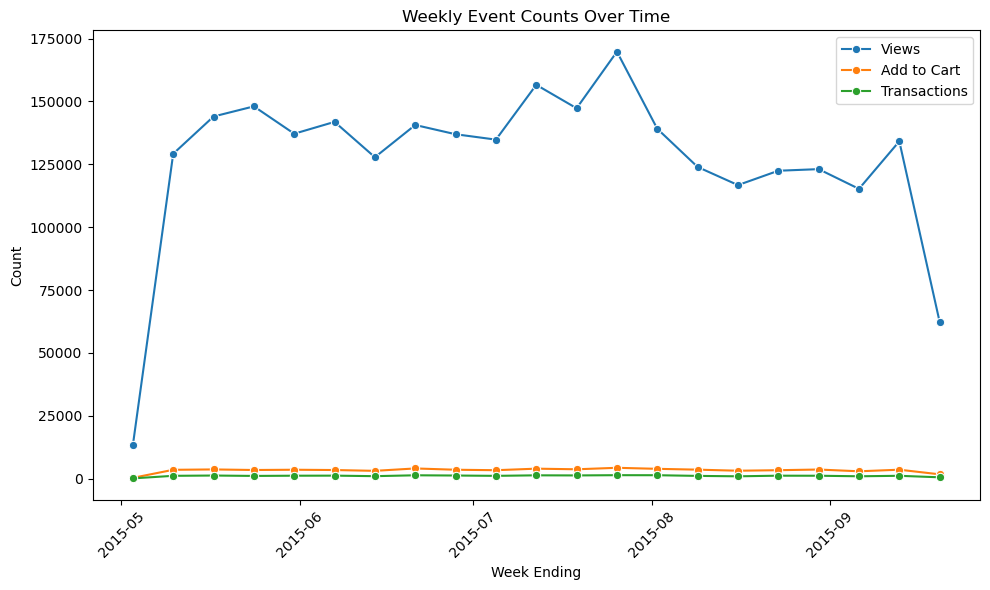

In [19]:
# show weekly_event_df data as a time series plot

# START [CoPilot]
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_event_df, x='timestamp', y='view', label='Views', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='addtocart', label='Add to Cart', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='transaction', label='Transactions', marker='o')

# sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_views', label='mean views', marker='o')
# sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_addtocart', label='mean addtocart', marker='o')
plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# END [CoPilot]

Here we can see that views are the highest value, and the add to carts and transactions are much lower. This graph includes weekly aggregates of view, addtocart, and transaction values, so shows trends over weeks and months. It seems that views are relatively consistent, but spike in late July-early August with a dip in views after. I am assuming the first and last weeks are low because data collection started midweek, so will disregard these. The addtocart and transactions so appear to spike a bit to match with the July-August spike in views, but are far less than the view values overall.

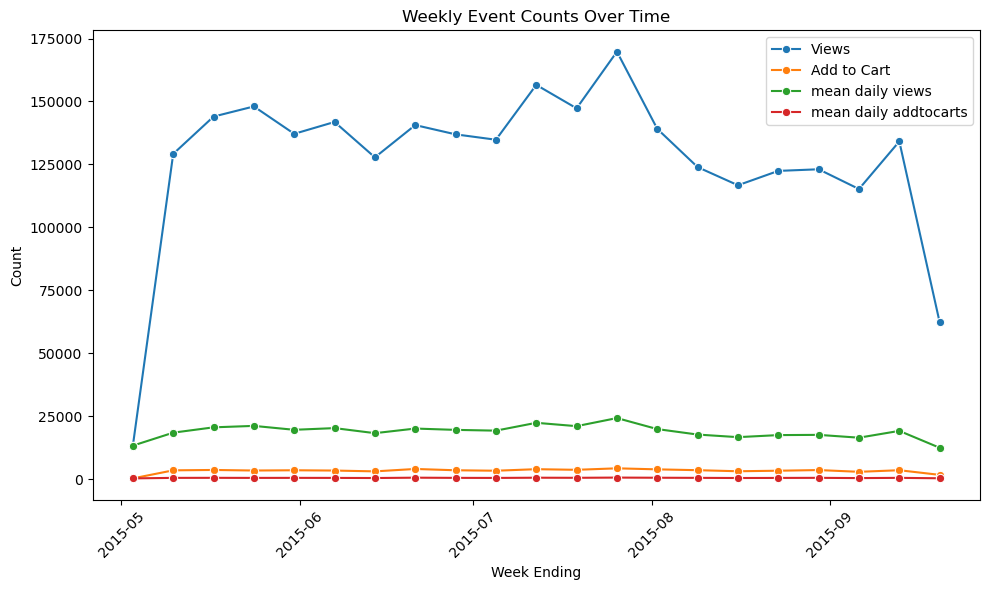

In [20]:
# show graph with daily means of views and addtocart for comparison

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_event_df, x='timestamp', y='view', label='Views', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='addtocart', label='Add to Cart', marker='o')
# sns.lineplot(data=weekly_event_df, x='timestamp', y='transaction', label='Transactions', marker='o')

sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_daily_views', label='mean daily views', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_daily_addtocart', label='mean daily addtocarts', marker='o')
plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In this graph, the aggregated weekly views and addtocarts are compared to the daily mean views and addtocarts. We can see that daily means are much smaller, but do reflect the overall shape of the view and addtocart data.

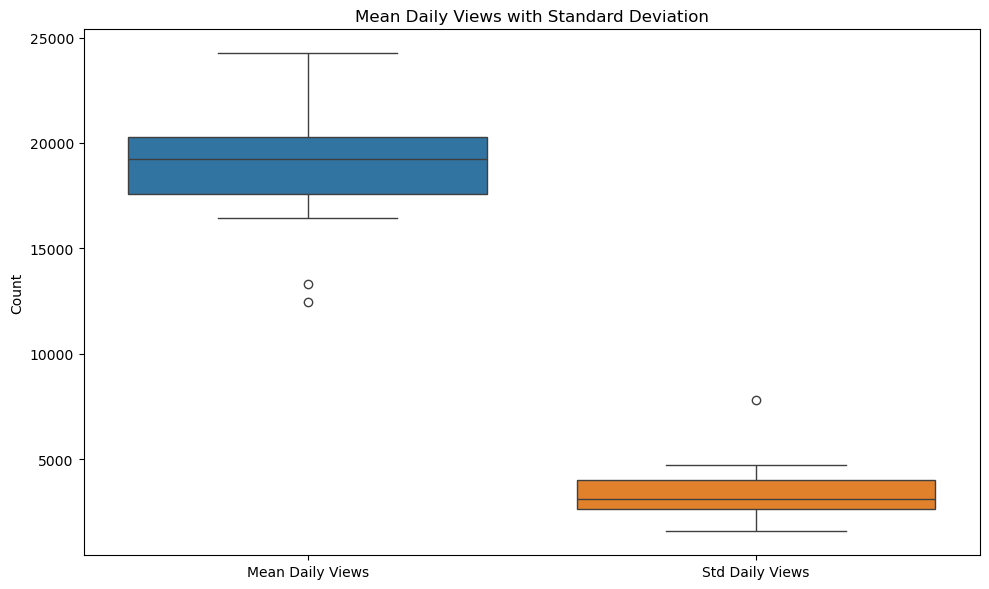

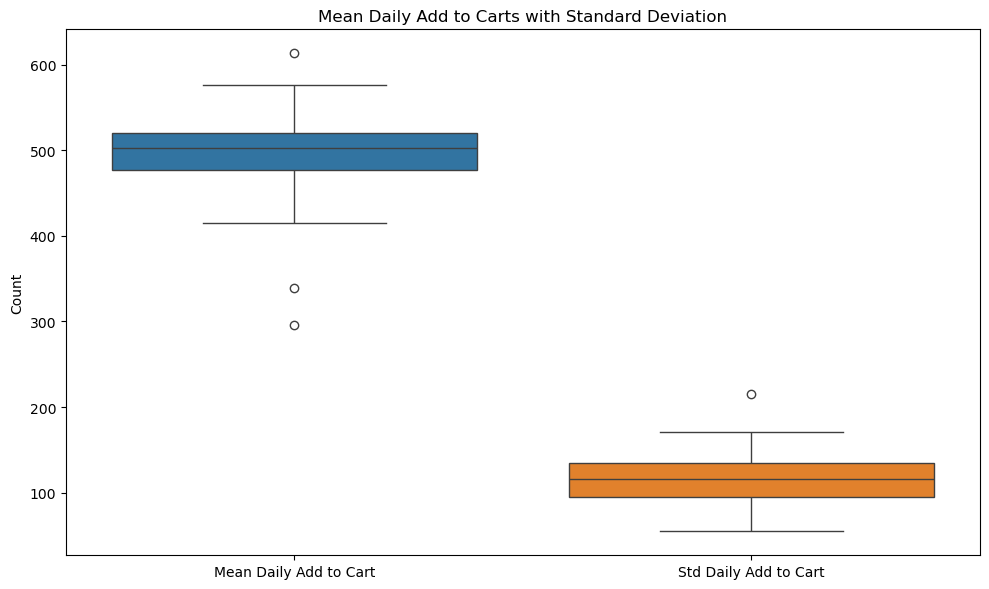

In [21]:
# make box plot of mean views and addtocarts with stadard deviation as error bars
# START [CoPilot]
plt.figure(figsize=(10, 6))
sns.boxplot(data=weekly_event_df[['mean_daily_views', 'std_daily_views']])
plt.title('Mean Daily Views with Standard Deviation')
plt.ylabel('Count')
plt.xticks([0, 1], ['Mean Daily Views', 'Std Daily Views'])
plt.tight_layout()
plt.show()
# END [CoPilot]

plt.figure(figsize=(10, 6))
sns.boxplot(data=weekly_event_df[['mean_daily_addtocart', 'std_daily_addtocart']])
plt.title('Mean Daily Add to Carts with Standard Deviation')
plt.ylabel('Count')
plt.xticks([0, 1], ['Mean Daily Add to Cart', 'Std Daily Add to Cart'])
plt.tight_layout()
plt.show()

These boxplots show some high and low outliers in the addtocart and views values, which I expect are the beginning and end values, as well as the July-August spike. I will remove the first and last values from the dataset to compare accuracy when we begin using the regression model.

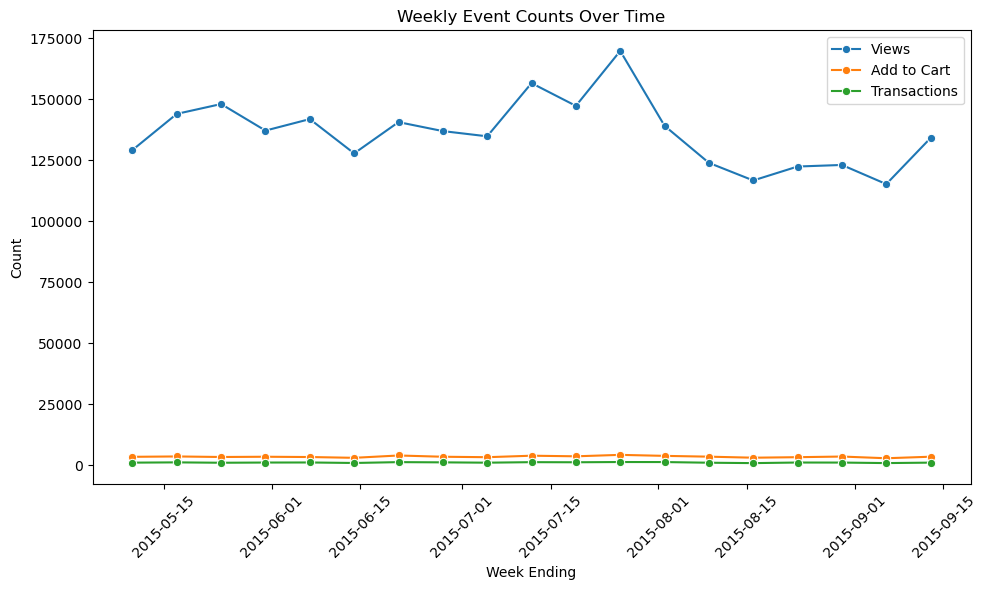

In [22]:
# drop first and last row of weekly_event_df to remove incomplete weeks
# START [CoPilot]
cleaned_weekly_event_df = weekly_event_df.iloc[1:-1].reset_index(drop=True)
# END [CoPilot]

# check if they are removed
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleaned_weekly_event_df, x='timestamp', y='view', label='Views', marker='o')
sns.lineplot(data=cleaned_weekly_event_df, x='timestamp', y='addtocart', label='Add to Cart', marker='o')
sns.lineplot(data=cleaned_weekly_event_df, x='timestamp', y='transaction', label='Transactions', marker='o')

plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



This cleaned dataframe is a better indication of the values since it doesn't have the midweek collection start and end artifacts biasing the data.

#### weekly mean and standard deviation of views, addtocarts, transactions (by product)

I also want to see the engagement by product, not aggregated by all products per week as above. This will help me compare product popularity as opposed to activity over time. 

In [23]:
# calculating weekly mean and std for views, addtocart, and transactions by product only (not week)

# START [ChatGPT 4.o] "i would like to calculate the weekly mean and standard deviation views, addtocarts, and transactions per product. i don't want a timestamp for the week, i just want the productid as the key and then to calculate an average weekly addtocarts, views, and transactions based on the data from each week. i also want the standard deviation for each of the means. can i also get the total views, addtocarts, and transactions over the entire timeframe"

event_df_copy['timestamp'] = pd.to_datetime(event_df_copy['timestamp'])

# aggregate by week (for mean)
weekly_counts = (
    event_df_copy
    .groupby(['itemid', pd.Grouper(key='timestamp', freq='W'), 'event'])
    .size()
    .unstack(fill_value=0)  # view, addtocart, transaction become columns
    .reset_index()
)

# group by product not week
product_weekly_stats = (
    weekly_counts
    .groupby('itemid')
    .agg(
        mean_views=('view', 'mean'),
        std_views=('view', 'std'),
        mean_addtocart=('addtocart', 'mean'),
        std_addtocart=('addtocart', 'std'),
        mean_transactions=('transaction', 'mean'),
        std_transactions=('transaction', 'std')
    )
    .reset_index()
)

# get total counts of views, addtocart, and transactions by product
total_counts = (
    event_df_copy
    .groupby(['itemid', 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={
        'view': 'total_views',
        'addtocart': 'total_addtocarts',
        'transaction': 'total_transactions'
    })
)

# merge means/std and total counts
product_summary = product_weekly_stats.merge(total_counts, on='itemid', how='left')
product_summary.head(10)

# END [ChatGPT 4.o]

,itemid,mean_views,std_views,mean_addtocart,std_addtocart,mean_transactions,std_transactions,total_addtocarts,total_transactions,total_views
0,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
1,4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,3
2,6,2.071429,1.384768,0.000000,0.000000,0.000000,0.000000,0,0,29
3,9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
4,15,2.250000,2.052873,0.375000,0.744024,0.125000,0.353553,3,1,18
5,16,2.142857,1.214986,0.000000,0.000000,0.000000,0.000000,0,0,15
6,17,1.500000,0.707107,0.000000,0.000000,0.000000,0.000000,0,0,3
7,19,1.777778,0.833333,0.111111,0.333333,0.111111,0.333333,1,1,16
8,22,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
9,24,1.000000,NaN,0.000000,NaN,0.000000,NaN,0,0,1


This gives me a better idea of the comparative product popularity between products, and the margins for error (std).

#### weekly views, addtocart, transaction by product.

I also can get the product activity per product and per week to analyze both time series trends and compare product popularity.

In [24]:
# get table of weekly interactions by product, week, and event type

# START [ChatGPT 4.o] "i want to group the data by product, week, and event type. how would i do that?"
# Group by product, week, and event type
event_df_copy['timestamp'] = pd.to_datetime(event_df_copy['timestamp'])

weekly_product_interactions = (
    event_df_copy
    .groupby([
        'itemid',
        pd.Grouper(key='timestamp', freq='W'),  # week ending on Sunday
        'event'
    ])
    .size()
    .unstack(fill_value=0)  # pivot events into columns
    .reset_index()
)
# END [ChatGPT 4.o]

weekly_product_interactions.head(10)


event,itemid,timestamp,addtocart,transaction,view
0,3,2015-08-23,0,0,1
1,3,2015-09-06,0,0,1
2,4,2015-07-05,0,0,1
3,4,2015-09-06,0,0,1
4,4,2015-09-20,0,0,1
5,6,2015-05-10,0,0,2
6,6,2015-05-24,0,0,1
7,6,2015-05-31,0,0,2
8,6,2015-06-07,0,0,6
9,6,2015-06-14,0,0,3


### Contextual / Item-Level Features (optional)

- `availability_weeks`: Weeks since the item first became available
- `num_of_sales_for_parent_category_per_week`: Aggregated sales of all items in the same parent category

In [25]:
# insert if i have time

### Engagement Ratios (choose at least 1)

- **Add-to-cart to view ratio**:  
  \[
  \text{ratio} = \frac{\text{num add to cart}}{\text{num views} + 1}
  \]

- **Category-level engagement**:  
  Ratio of add-to-carts to views at the parent category level

#### addtocart-to-view ratio (by product by week)

In [55]:
# calculate add to cart to view ratio for weekly_event_df

weekly_event_df['addtocart_to_view_ratio'] = (
    weekly_event_df['addtocart'] / weekly_event_df['view']
).replace([np.inf, -np.inf], np.nan)  # replace inf values with NaN

weekly_event_df.head(10)


,timestamp,addtocart,transaction,view,mean_daily_views,std_daily_views,mean_daily_addtocart,std_daily_addtocart,addtocart_to_view_ratio
0,2015-05-03,296,83,13304,13304.000000,NaN,296.000000,NaN,0.022249
1,2015-05-10,3492,1103,129180,18454.285714,4697.232331,498.857143,143.386922,0.027032
2,2015-05-17,3642,1218,144001,20571.571429,2641.574080,520.285714,98.159249,0.025291
3,2015-05-24,3419,1061,148034,21147.714286,3980.165395,488.428571,134.244624,0.023096
4,2015-05-31,3520,1146,137153,19593.285714,2914.119862,502.857143,89.214028,0.025665
5,2015-06-07,3405,1174,141866,20266.571429,3252.272685,486.428571,98.341001,0.024002
6,2015-06-14,3081,966,127805,18257.857143,4554.762542,440.142857,119.330673,0.024107
7,2015-06-21,4036,1316,140624,20089.142857,3576.700222,576.571429,170.632018,0.028701
8,2015-06-28,3520,1222,136946,19563.714286,2880.310962,502.857143,112.620940,0.025704
9,2015-07-05,3337,1089,134807,19258.142857,2740.018457,476.714286,55.002164,0.024754


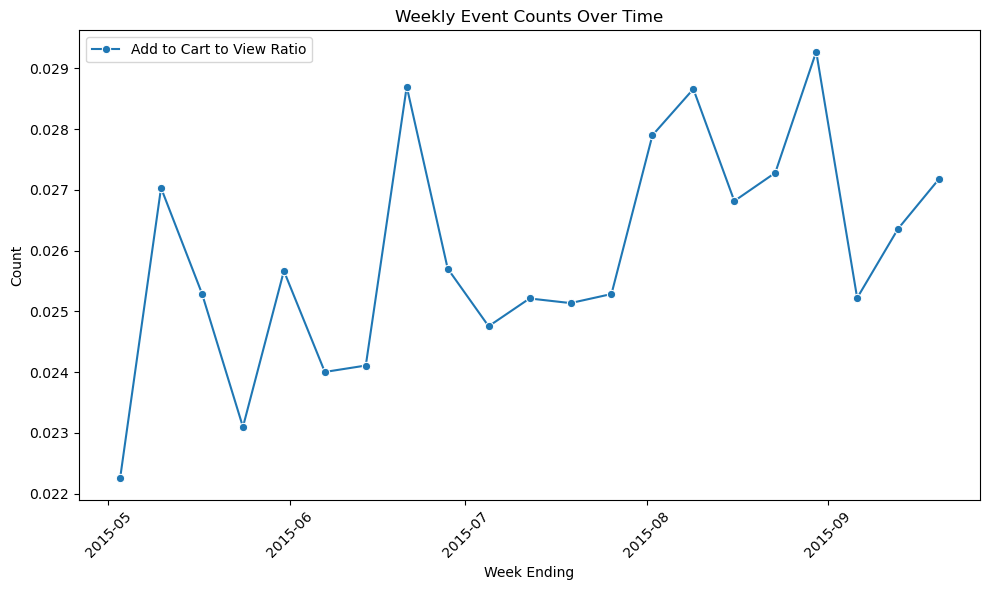

In [56]:
# plot ratio over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_event_df, x='timestamp', y='addtocart_to_view_ratio', label='Add to Cart to View Ratio', marker='o')

plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


To explore how the view number impacts the number of times items are added to cart, we can compute the add to cart to view ratio by dividing the number of times an item is added to the cart by the number of views. I added this to the existing weekly_event_df dataset with the other weekly aggregates, means, and standard deviations. The plot shows that the ratio changes over time, but within a very small range of 0.022 to 0.029, so in actuality stays relatively consistent.

### Recency Features (choose at least 1)

- Days since last view or add-to-cart
- Was the item viewed/added this week? (binary feature)

#### days since last product view (by product by week)

In [27]:
# adding days since product was last viewed to weekly_product_interactions dataframe 

# START [ChatGPT 4.o] "i want to get the 'days since last view' for each product that is based on the date of the most recent view event. i"
event_df_copy['timestamp'] = pd.to_datetime(event_df_copy['timestamp'])
latest_timestamp = event_df_copy['timestamp'].max()

views_only = event_df_copy[event_df_copy['event'] == 'view']

last_view_per_product = (
    views_only
    .groupby('itemid')['timestamp']
    .max()
    .reset_index()
    .rename(columns={'timestamp': 'last_view_date'})
)

last_view_per_product['days_since_last_view'] = (
    latest_timestamp - last_view_per_product['last_view_date']
).dt.days

# last_view_per_product.head(10)
# END[ChatGPT 4.o]

# merge with weekly_product_interactions
weekly_product_interactions = weekly_product_interactions.merge(
    last_view_per_product[['itemid', 'days_since_last_view']],
    on='itemid',
    how='left'
)

weekly_product_interactions.head(10)


,itemid,timestamp,addtocart,transaction,view,days_since_last_view
0,3,2015-08-23,0,0,1,17.0
1,3,2015-09-06,0,0,1,17.0
2,4,2015-07-05,0,0,1,2.0
3,4,2015-09-06,0,0,1,2.0
4,4,2015-09-20,0,0,1,2.0
5,6,2015-05-10,0,0,2,21.0
6,6,2015-05-24,0,0,1,21.0
7,6,2015-05-31,0,0,2,21.0
8,6,2015-06-07,0,0,6,21.0
9,6,2015-06-14,0,0,3,21.0


Here I added the days since last view to show the activity level for each product. This will give a quick at-a-glance metric for which products are currently popular and which are not attracting customer attention. The binary feature is already included in that you can just test for the values of the view, transaction, or addtocart columns and if it is more than 1, it is true.

### Diversity of Audience (choose at least 1)

- Number of **unique users** who viewed or added the item this week
- Number of **returning users** who interacted with it in previous weeks (*may be more challenging*)

#### number of unique viewers/adders (by product by week)

In [46]:
# calculating number of unique visitors who viewed or added item each week

# START [ChatGPT 4.o] "how would i calculate the number of unique visitors who have visited the product that week? i have a visitorid included in the events_df_copy data"
event_df_copy['timestamp'] = pd.to_datetime(event_df_copy['timestamp'])

filtered_events = event_df_copy[event_df_copy['event'].isin(['view', 'addtocart', 'transaction'])]

unique_user_counts = (
    filtered_events
    .groupby(['itemid', pd.Grouper(key='timestamp', freq='W'), 'event'])['visitorid']
    .nunique()
    .unstack(fill_value=0)  # events become columns
    .reset_index()
    .rename(columns={
        'view': 'unique_viewers',
        'addtocart': 'unique_adders',
        'transaction': 'unique_transactors'
    })
)

weekly_summary = weekly_product_interactions.merge(
    unique_user_counts,
    on=['itemid', 'timestamp'],
    how='left'
)

weekly_summary.head(10)

# END [ChatGPT 4.o]


,itemid,timestamp,addtocart,transaction,view,days_since_last_view,addtocart_to_transaction_ratio,unique_adders,unique_transactors,unique_viewers
0,3,2015-08-23,0,0,1,17.0,0.0,0,0,1
1,3,2015-09-06,0,0,1,17.0,0.0,0,0,1
2,4,2015-07-05,0,0,1,2.0,0.0,0,0,1
3,4,2015-09-06,0,0,1,2.0,0.0,0,0,1
4,4,2015-09-20,0,0,1,2.0,0.0,0,0,1
5,6,2015-05-10,0,0,2,21.0,0.0,0,0,1
6,6,2015-05-24,0,0,1,21.0,0.0,0,0,1
7,6,2015-05-31,0,0,2,21.0,0.0,0,0,2
8,6,2015-06-07,0,0,6,21.0,0.0,0,0,5
9,6,2015-06-14,0,0,3,21.0,0.0,0,0,3


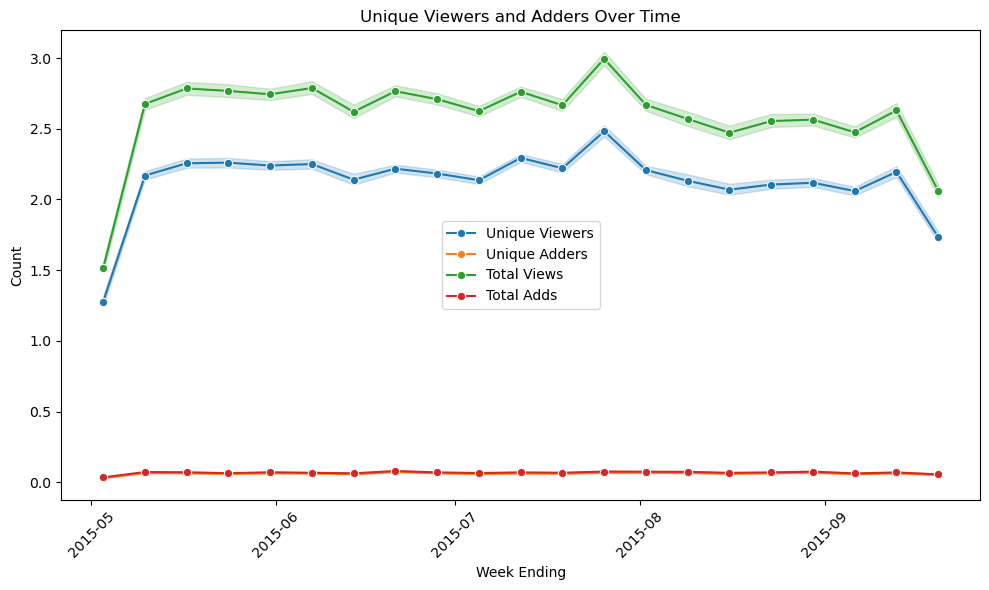

In [39]:
# plot unique viewers and adders over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_summary, x='timestamp', y='unique_viewers', label='Unique Viewers', marker='o')
sns.lineplot(data=weekly_summary, x='timestamp', y='unique_adders', label='Unique Adders', marker='o')  
sns.lineplot(data=weekly_summary, x='timestamp', y='view', label='Total Views', marker='o')
sns.lineplot(data=weekly_summary, x='timestamp', y='addtocart', label='Total Adds', marker='o')  
plt.title('Unique Viewers and Adders Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Calculating the unique adders and viewers gives an idea of if the view and add values are accurate, or skewed by a few very active users who repeatedly view and add to the cart. In this case, it appears that the unique viewers and adders correlate pretty closely to the normal amount of adders and views, so there aren't outliers from overactive users.

### Your Suggested Features (propose and use 2)

Propose at **least two other features** that you think would give you an edge for better prediction. Try them to complement or replace some of the other features. 

#### 1. addtocart-to-transaction ratio
To dig deeper into the conversion rates per product, I will calculate the addtocart to transaction ration to see which products are purchased most after they are added to the cart.

In [41]:
# calculate addtocart to transaction ratio for weekly_product_interactions

# START [ChatGPT 4.o] "how would i calculate a ratio of how many times products have been added to the cart versus how many times they are purchased (addtocart/transaction)"

weekly_product_interactions['addtocart_to_transaction_ratio'] = (
    (weekly_product_interactions['addtocart'] / weekly_product_interactions['transaction']
     .where(weekly_product_interactions['transaction'] != 0))
    .fillna(0)
)

weekly_product_interactions.head(10)

# END [ChatGPT 4.o]

,itemid,timestamp,addtocart,transaction,view,days_since_last_view,addtocart_to_transaction_ratio
0,3,2015-08-23,0,0,1,17.0,0.0
1,3,2015-09-06,0,0,1,17.0,0.0
2,4,2015-07-05,0,0,1,2.0,0.0
3,4,2015-09-06,0,0,1,2.0,0.0
4,4,2015-09-20,0,0,1,2.0,0.0
5,6,2015-05-10,0,0,2,21.0,0.0
6,6,2015-05-24,0,0,1,21.0,0.0
7,6,2015-05-31,0,0,2,21.0,0.0
8,6,2015-06-07,0,0,6,21.0,0.0
9,6,2015-06-14,0,0,3,21.0,0.0


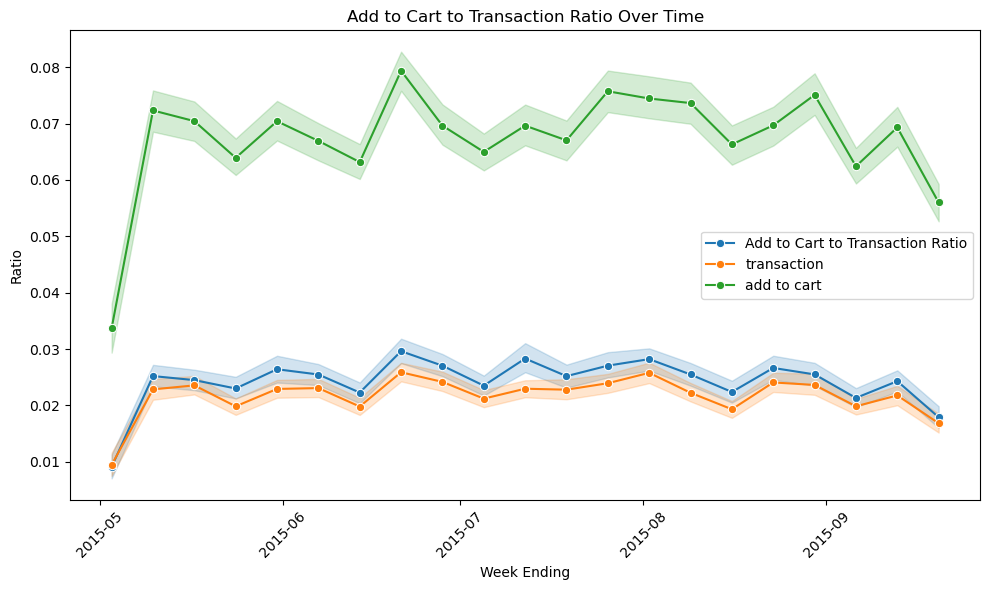

In [ ]:
# plot the addtocart to transaction ratio over time

# START [CoPilot]
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_product_interactions, x='timestamp', y='addtocart_to_transaction_ratio', label='Add to Cart to Transaction Ratio', marker='o')
sns.lineplot(data=weekly_product_interactions, x='timestamp', y='transaction', label='transaction', marker='o')
sns.lineplot(data=weekly_product_interactions, x='timestamp', y='addtocart', label='add to cart', marker='o')
plt.title('Add to Cart to Transaction Ratio Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# END [CoPilot]

This shows us that the number of add to carts is much higher than the actual transactions, and the ratio follows the general trend of overal views.

#### 2. unique viewers to add to cart ratio
This will tell us how many unique people have to see a listing for one of them to purchase it, so is a better proxy for conversion.

In [47]:
# calculate unique viewers to add to cart ratio for weekly_summary

# START [ChatGPT 4.o] "how would i calculate a ratio of how many
weekly_summary['unique_viewers_to_transaction_ratio'] = (
    (weekly_summary['unique_viewers'] / weekly_summary['transaction']
        .where(weekly_summary['transaction'] != 0))
    .fillna(0)
)
# END [ChatGPT 4.o]
weekly_summary.head(10)

,itemid,timestamp,addtocart,transaction,view,days_since_last_view,addtocart_to_transaction_ratio,unique_adders,unique_transactors,unique_viewers,unique_viewers_to_transaction_ratio
0,3,2015-08-23,0,0,1,17.0,0.0,0,0,1,0.0
1,3,2015-09-06,0,0,1,17.0,0.0,0,0,1,0.0
2,4,2015-07-05,0,0,1,2.0,0.0,0,0,1,0.0
3,4,2015-09-06,0,0,1,2.0,0.0,0,0,1,0.0
4,4,2015-09-20,0,0,1,2.0,0.0,0,0,1,0.0
5,6,2015-05-10,0,0,2,21.0,0.0,0,0,1,0.0
6,6,2015-05-24,0,0,1,21.0,0.0,0,0,1,0.0
7,6,2015-05-31,0,0,2,21.0,0.0,0,0,2,0.0
8,6,2015-06-07,0,0,6,21.0,0.0,0,0,5,0.0
9,6,2015-06-14,0,0,3,21.0,0.0,0,0,3,0.0


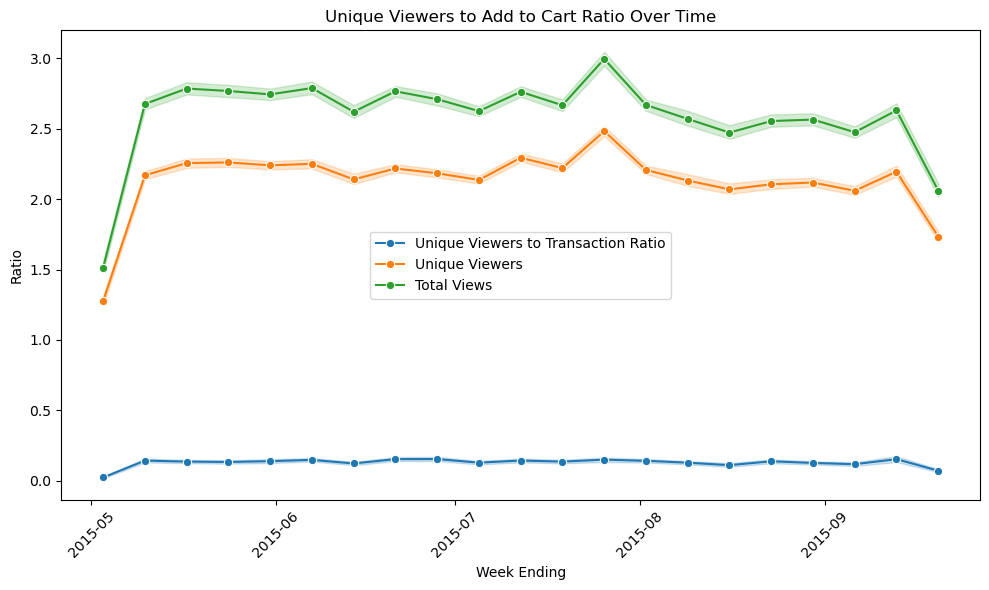

In [51]:
# plot unique viewers to transaction ratio over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_summary, x='timestamp', y='unique_viewers_to_transaction_ratio', label='Unique Viewers to Transaction Ratio', marker='o')
sns.lineplot(data=weekly_summary, x='timestamp', y='unique_viewers', label='Unique Viewers', marker='o')
sns.lineplot(data=weekly_summary, x='timestamp', y='view', label='Total Views', marker='o')
plt.title('Unique Viewers to Add to Cart Ratio Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Again, the line follows the general trend of viewers, implying that as views go up, they are mainly unique viewers, which leads to more adding to cart and transactions.

--- 
## 3. Regression Task

a. Start by creating a **baseline model** using only `weekly_views` and `weekly_add_to_cart` as features.

First I'll review the dataframes I have to work with. I'll be drawing features from these to test the regression models.

In [59]:
# all events by timestamp with time of day and day of week
event_df_copy.head(10)


,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour,time_of_day
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2,5,night
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2,5,night
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2,5,night
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2,5,night
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2,5,night
5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2,5,night
6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2,5,night
7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2,5,night
8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2,4,night
9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2,5,night


In [57]:
# weekly total interactions
weekly_event_df.head(10)

,timestamp,addtocart,transaction,view,mean_daily_views,std_daily_views,mean_daily_addtocart,std_daily_addtocart,addtocart_to_view_ratio
0,2015-05-03,296,83,13304,13304.000000,NaN,296.000000,NaN,0.022249
1,2015-05-10,3492,1103,129180,18454.285714,4697.232331,498.857143,143.386922,0.027032
2,2015-05-17,3642,1218,144001,20571.571429,2641.574080,520.285714,98.159249,0.025291
3,2015-05-24,3419,1061,148034,21147.714286,3980.165395,488.428571,134.244624,0.023096
4,2015-05-31,3520,1146,137153,19593.285714,2914.119862,502.857143,89.214028,0.025665
5,2015-06-07,3405,1174,141866,20266.571429,3252.272685,486.428571,98.341001,0.024002
6,2015-06-14,3081,966,127805,18257.857143,4554.762542,440.142857,119.330673,0.024107
7,2015-06-21,4036,1316,140624,20089.142857,3576.700222,576.571429,170.632018,0.028701
8,2015-06-28,3520,1222,136946,19563.714286,2880.310962,502.857143,112.620940,0.025704
9,2015-07-05,3337,1089,134807,19258.142857,2740.018457,476.714286,55.002164,0.024754


In [54]:
# weekly interactions by product by week
weekly_summary.head(10)

,itemid,timestamp,addtocart,transaction,view,days_since_last_view,addtocart_to_transaction_ratio,unique_adders,unique_transactors,unique_viewers,unique_viewers_to_transaction_ratio
0,3,2015-08-23,0,0,1,17.0,0.0,0,0,1,0.0
1,3,2015-09-06,0,0,1,17.0,0.0,0,0,1,0.0
2,4,2015-07-05,0,0,1,2.0,0.0,0,0,1,0.0
3,4,2015-09-06,0,0,1,2.0,0.0,0,0,1,0.0
4,4,2015-09-20,0,0,1,2.0,0.0,0,0,1,0.0
5,6,2015-05-10,0,0,2,21.0,0.0,0,0,1,0.0
6,6,2015-05-24,0,0,1,21.0,0.0,0,0,1,0.0
7,6,2015-05-31,0,0,2,21.0,0.0,0,0,2,0.0
8,6,2015-06-07,0,0,6,21.0,0.0,0,0,5,0.0
9,6,2015-06-14,0,0,3,21.0,0.0,0,0,3,0.0


In [58]:
# product stats
product_summary.head(10)

,itemid,mean_views,std_views,mean_addtocart,std_addtocart,mean_transactions,std_transactions,total_addtocarts,total_transactions,total_views
0,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
1,4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,3
2,6,2.071429,1.384768,0.000000,0.000000,0.000000,0.000000,0,0,29
3,9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
4,15,2.250000,2.052873,0.375000,0.744024,0.125000,0.353553,3,1,18
5,16,2.142857,1.214986,0.000000,0.000000,0.000000,0.000000,0,0,15
6,17,1.500000,0.707107,0.000000,0.000000,0.000000,0.000000,0,0,3
7,19,1.777778,0.833333,0.111111,0.333333,0.111111,0.333333,1,1,16
8,22,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
9,24,1.000000,NaN,0.000000,NaN,0.000000,NaN,0,0,1


Next I'll run the baseline model with only weekly view and weekly add to cart as features to predict the weekly sales count.

In [30]:
# we are interested in the number of successful purchases per item per week 

# reviewing what we got earlier
print(weekly_sales_count.head(50))

    itemid  timestamp  sales_count
0       15 2015-07-12            1
1       19 2015-08-16            1
2       25 2015-06-14            1
3       25 2015-08-09            1
4       42 2015-08-16            1
5      147 2015-09-06            4
6      168 2015-09-20            1
7      199 2015-07-19            1
8      212 2015-06-21            1
9      233 2015-06-21            1
10     304 2015-09-20            1
11     320 2015-06-21            1
12     387 2015-08-09            1
13     403 2015-06-14            1
14     496 2015-06-14            1
15     496 2015-06-21            1
16     546 2015-07-26            3
17     546 2015-08-02            5
18     546 2015-08-09            2
19     546 2015-08-16            2
20     546 2015-08-23            9
21     546 2015-08-30            2
22     563 2015-07-26            1
23     572 2015-06-21            1
24     651 2015-06-07            1
25     655 2015-08-02            1
26     698 2015-09-13            1
27     720 2015-08-2

In [31]:
# linear regression model with sklearn from class

#define function that will run a linear regression and returns the regression formula for the model
def run_LR(X, y, predictors):


    #build multiple linear regression model
    model = LinearRegression()

    #fit the model to the data
    model.fit(X, y)

    #pint model summary

    #print regression formula
    print("\nRegression formula: y = ", end="")
    for i in range(len(model.coef_)):
        if i == 0:
            print(f"{model.intercept_:.3f} + \n{model.coef_[i]:.3f} * {predictors[i]}", end="")
        else:
            print(f" + \n{model.coef_[i]:.3f} * {predictors[i]}", end="")
    print()
    
    #predct the target variable
    y_pred = model.predict(X)
    
    #print root mean squared error
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))
    print(f"RMSE: {rmse:.1f}")
    #print r-squared
    r_squared = model.score(X, y)
    print(f"R-squared: {r_squared:.3f}")


#### baseline model

In [62]:
# run baseline model

feature_cols = ['view', 'addtocart']

subset = weekly_summary.dropna(subset=feature_cols + ['transaction'])

X = subset[feature_cols]
y = subset['transaction']

run_LR(X, y, feature_cols)


Regression formula: y = -0.007 + 
0.004 * view + 
0.268 * addtocart
RMSE: 0.1
R-squared: 0.394


Here we have a baseline model to compare feature models to. 
- The views are not that tied to transactions, and only increase transaction likelihood by 0.04%, the addtocarts increase transaction likelihood by 26.8%. 
- The RMSE is very small, and means that the average error between actual and predicted transactions is 1%, which indicates high accuracy already with the base model. 
- The R² indicates that 39.4% of transaction variance is explained by views and addtocarts, which is below chance, so not that strong of a result.

Values
- 0.004 - view is very slightly positively correlated, which means that the more views a product receives, the more people buy it, but only by a very small margin since many more people view than purchase.
- 0.268 - addtocart is more positively correlated, meaning if someone adds a product to the cart they are likely to check it out and buy it.

Let's see if scaling the inputs has any impact on the results.

In [63]:
# run baseline model with scaled features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

run_LR(X_scaled, y, feature_cols)


Regression formula: y = 0.022 + 
0.020 * view + 
0.108 * addtocart
RMSE: 0.1
R-squared: 0.394


Scaling the results resulted in a small increase in view impact on transactions, but otherwise reduced or kept results the same. This indicates that results are not in need of scaling for now so we will compare to the original baseline model.

---
b. Then, add your engineered features in **different combinations**, and compare the results using metrics like **RMSE** and **R²**. For each model, reflect on:

- Why each feature might have a **positive**, **negative**, or **no impact** on the target
- You may need to use correlation, distributions, or explore other solutions to support your reasoning. 

#### weekly aggregate data

This dataframe contains data aggregated by week only, with total, mean, and standard deviation for addtocarts, views, and transactions.

In [65]:
# adding all engineered features in weekly_event_df to model

feature_cols = ['view', 'addtocart', 'mean_daily_views', 'mean_daily_addtocart', 'std_daily_views', 'std_daily_addtocart', 'addtocart_to_view_ratio']

subset = weekly_event_df.dropna(subset=feature_cols + ['transaction'])

X = subset[feature_cols]
y = subset['transaction']

run_LR(X, y, feature_cols)


Regression formula: y = 4383.286 + 
-0.040 * view + 
1.619 * addtocart + 
0.054 * mean_daily_views + 
0.233 * mean_daily_addtocart + 
-0.003 * std_daily_views + 
-0.145 * std_daily_addtocart + 
-176384.573 * addtocart_to_view_ratio
RMSE: 45.9
R-squared: 0.941


When I add all the weekly_event_df engineered features, the RMSE shoots up from 0.1 to 45.9, meaning the average error is 45.9%, which is almost at chance. This could indicate poor performance compared to the previous baseline model at 0.1, however, the R² is much higher than the baseline model, which only predicted 39.4% of transaction variation. This one's features predict 94.1% of the transaction variation, so clearly the added features have some value.

Values
- -0.040 - view is negatively correlated, this doesn't make sense since transactions increased based on view count in the visualizations above, however the number is so small we can likely write it off as a quirk of the model.
- 1.619 - addtocart is positively correlated with transaction which makes sense since users would likely add a product to the cart before checking it out.
- 0.054 - mean daily views is very slightly positively correlated, as the more views an item receives, the more likely it is to be added to the cart and transacted.
- 0.233 - mean daily addtocart is very slightly negatively correlated which doesn't make sense since addtocart itself is positively correlated, but since it is small we will not consider it.
- -0.003 - std daily views is very slighyly negatively correlated which makes sense since a smaller standard deviation means a tighter cluster, so more corerlation between variables.
- -0.145 - std daily addtocart is slightly negatively correlated which makes sense since a smaller standard deviation means a tighter cluster, so more corerlation between variables.


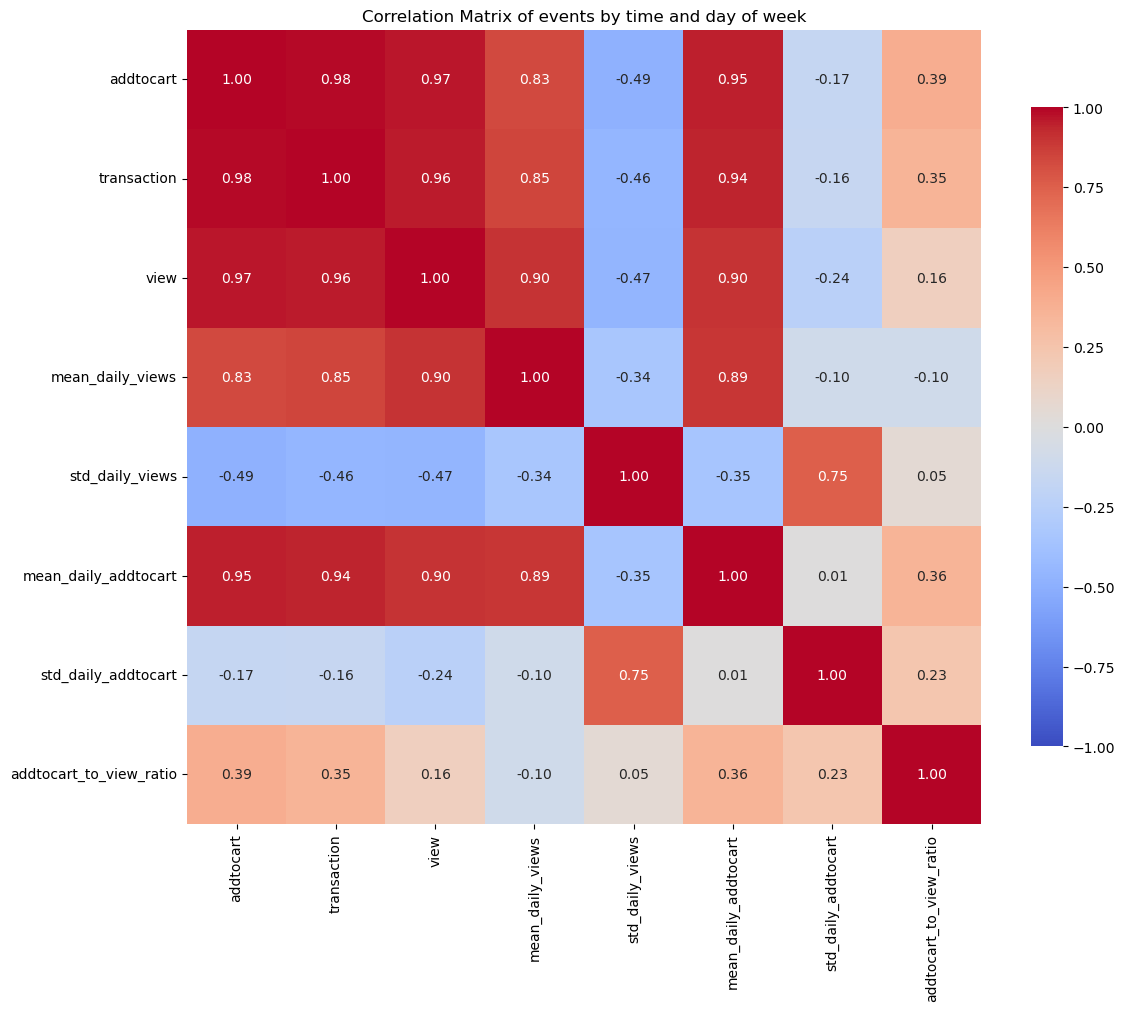

In [106]:
# plot correlation matrix of all features in weekly_event_df

correlation_matrix = weekly_event_df.drop(columns=['timestamp']).corr() #dropping timestamp since datetime doesn't work in correlation matrix
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of events by time and day of week')
plt.tight_layout()
plt.show()

The features in this dataframe are all quite correlated to each other. We can see that the views, addtocarts, and transactions are all highly correlated. This means some of the data is redundant, so let's get rid of the means since they are all highly correlated to actual values so are redundant data. The ratio and standard deviations are less highly correlated so may be good to expand the model range past what it already knows.

In [109]:
# drop redundant columns

weekly_event_df_corr = weekly_event_df.drop(columns=['mean_daily_views', 'mean_daily_addtocart', 'timestamp'])

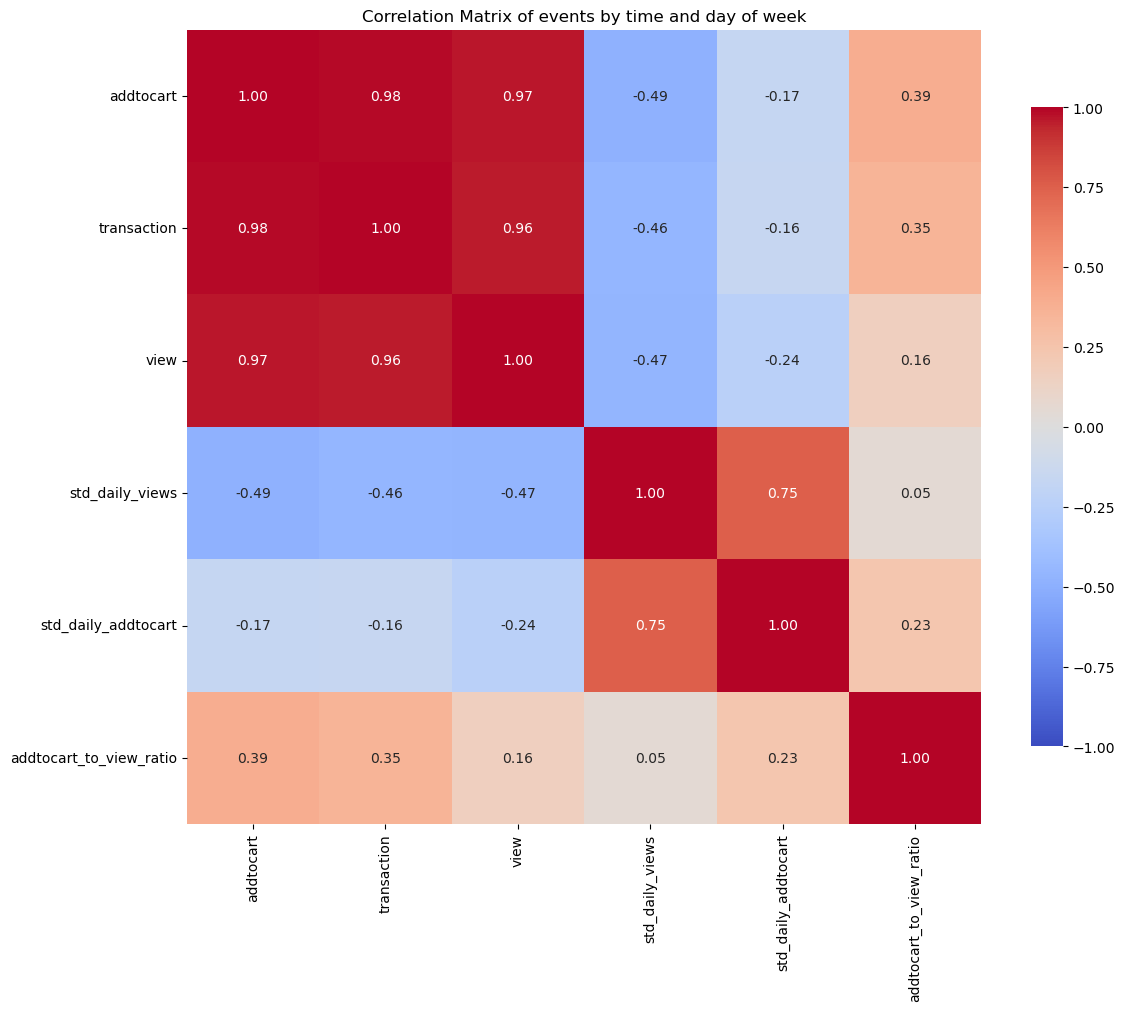

In [110]:
correlation_matrix = weekly_event_df_corr.corr() 
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of events by time and day of week')
plt.tight_layout()
plt.show()

In [111]:
# running model for reduced features

feature_cols = ['view', 'addtocart', 'std_daily_views', 'std_daily_addtocart', 'addtocart_to_view_ratio']

subset = weekly_event_df_corr.dropna(subset=feature_cols + ['transaction'])

X = subset[feature_cols]
y = subset['transaction']

run_LR(X, y, feature_cols)


Regression formula: y = 2609.611 + 
-0.019 * view + 
1.075 * addtocart + 
0.002 * std_daily_views + 
0.208 * std_daily_addtocart + 
-103530.857 * addtocart_to_view_ratio
RMSE: 48.3
R-squared: 0.934


This model performs worse compared to the previous, likely because there is less data to train on so it is less robust. We will keep to the previous model, since the RMSE and R² are lower.

Previous model results (all features) for comparison:
- Regression formula: y = 4383.286 + 
-0.040 * view + 
1.619 * addtocart + 
0.054 * mean_daily_views + 
0.233 * mean_daily_addtocart + 
-0.003 * std_daily_views + 
-0.145 * std_daily_addtocart + 
-176384.573 * addtocart_to_view_ratio
- RMSE: 45.9
- R-squared: 0.941

#### weekly data by product

This dataframe contains data aggregated by week for each item, and includes the number of addtocarts, transactions, views, days since last view, actions from unique visitors, and ratios of addtocart to transactions, and unique viewers to transactions.

In [66]:
# adding basic features from weekly_summary of products by week to model

feature_cols = ['view', 'addtocart']

subset = weekly_summary.dropna(subset=feature_cols + ['transaction'])

X = subset[feature_cols]
y = subset['transaction']

run_LR(X, y, feature_cols)


Regression formula: y = -0.007 + 
0.004 * view + 
0.268 * addtocart
RMSE: 0.1
R-squared: 0.394


Using the same raw features from the baseline model but with this weekly data by product dataframe yields the same results as the baseline model, which is good as it tells us the data was not distorted in the feature engineering process. Now let's add some more features.

In [67]:
# adding all features from weekly_summary of products by week to model

feature_cols = ['view', 'addtocart', 'days_since_last_view', 'unique_viewers', 'unique_adders', 'unique_transactors', 'addtocart_to_transaction_ratio', 'unique_viewers_to_transaction_ratio']

subset = weekly_summary.dropna(subset=feature_cols + ['transaction'])

X = subset[feature_cols]
y = subset['transaction']

run_LR(X, y, feature_cols)


Regression formula: y = -0.000 + 
0.001 * view + 
0.058 * addtocart + 
0.000 * days_since_last_view + 
-0.001 * unique_viewers + 
-0.060 * unique_adders + 
1.069 * unique_transactors + 
-0.028 * addtocart_to_transaction_ratio + 
-0.001 * unique_viewers_to_transaction_ratio
RMSE: 0.0
R-squared: 0.966


The weekly_summary features seem to have been very helpful, as the RMSE and R² have significantly improved. 
- The RMSE is now 0.0, indicating a very small, likely rounded down, error between predictions and actual results. 
- The R² means the model accounts for 96.6% of the transaction variance, which is the highest so far.

Values
- 0.001 - view is less correlated than in the baseline model, but is still positive, indicating that the more views a product gets, the more it is purchased per week.
- 0.058 - addtocart is slightly positively correlated with transaction which means the more a product is added to the cart each week, the more it is purchased.
- 0.000 - days since last view is not correlated at all, meaning the time last viewed does not relate to the amount of purchases in the last week.
- -0.001 - number of unique viewers is slightly negatively correlated, meaning the less people that view a product the more purchases there are. This is a very small value so could be a quirk of the model to dismiss, but could also suggest that the more the same person is repeatedly looking at a product, the more likely there is to be a sale, which makes intuitive sense.
- -0.060 - number of unique adders is also slightly negatively correlated, which could also mean the less individual people that add an item to the cart, the more likely it is to be purchased, potentially because the same person considering a product would add it to the cart several times.
- 1.069 - unique transactors is highly positively correlated with transactions, which makes sense since the more people who are making transactions, the more transactions are actually being made.
- -0.028 - addtocart to transaction ratio is slightly negatively correlated which means that the smaller the ratio is the more transactions happen.
- -0.001 - unique viewers to transaction ratio is also slightly negatively correlated which means that the smaller the ratio is the more transactions happen.

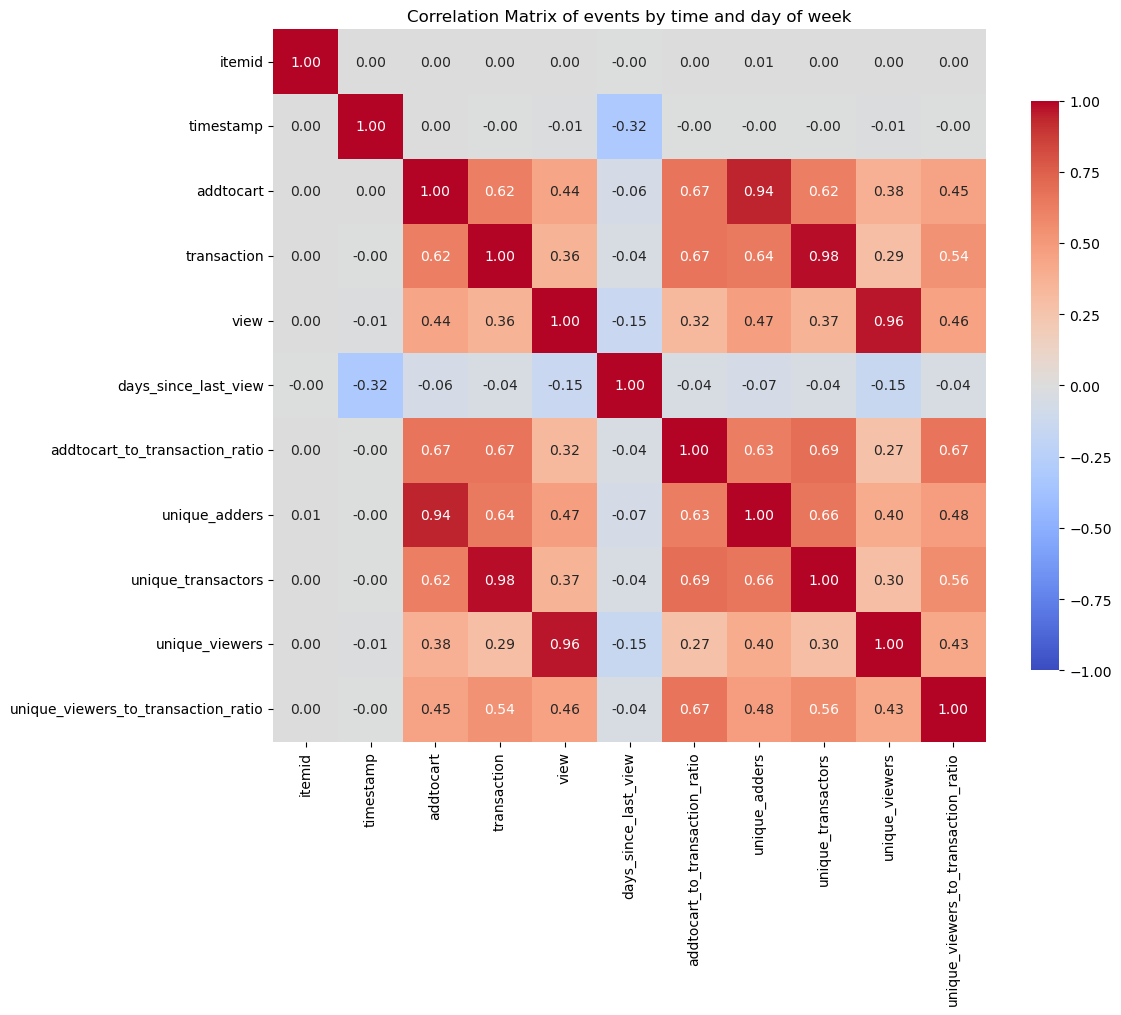

In [103]:
# plot correlation matrix of all features in weekly_summary

correlation_matrix = weekly_summary.corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of events by time and day of week')
plt.tight_layout()
plt.show()

This correlation matrix shows that nothing but the itemid, which already isn't included in the linear regression, is uncorrelated to anything, so we don't need to drop anything from the model. The most related are the unique add/view/transactors and the number of these events which is intuitive, so we will leave it in.

#### products by transaction

Now let's look at products by transactions. Here, the means and standard deviations are aggregates of daily views, addtocarts, and transactions. In this way, we can use the mean transactions as a predictor.

In [69]:
# adding all features from product_summary

feature_cols = ['mean_views', 'std_views', 'mean_addtocart', 'std_addtocart','std_transactions', 'total_views', 'total_addtocarts', 'total_transactions']

subset = product_summary.dropna(subset=feature_cols + ['mean_transactions'])

X = subset[feature_cols]
y = subset['mean_transactions']

run_LR(X, y, feature_cols)


Regression formula: y = -0.003 + 
0.004 * mean_views + 
-0.001 * std_views + 
0.237 * mean_addtocart + 
-0.090 * std_addtocart + 
0.353 * std_transactions + 
-0.000 * total_views + 
-0.009 * total_addtocarts + 
0.031 * total_transactions
RMSE: 0.0
R-squared: 0.920


The results for this model of product data aggregates is also pretty good, although not as much as the previous model using the weekly summaries.
- The RMSE is again 0.0, meaning the error is very small and likely rounded to 0. 
- The R² means that the modeled columns account for 92% of the transaction variation, which is slighly less accurate than the previous model.

Values
- 0.004 - mean views is slightly positively correlated which makes sense since the more views a product gets, the more likely someone is to buy.
- -0.001 - std views is slightly negatively correlated which means the smaller the std (the tighter the cluster), the more likely there is to be a transaction.
- 0.237 - mean addto cart is positively correlated, meaning that the more addtocarts there are, the more transactions there are
- -0.090 - std addtocart is slightly negatively correlated which makes sense, since the smaller the std is (the tighter cluster), the more transactions happen.
- 0.353 - std transactions is positively correlated to the transactions, which makes sense since they are about the same metric, so would get higher or lower together.
- -0.000 - total views shows as not correlated at all, which does not make sense considering the relation in the previous models, however the correlation was always small, so in this case it may not be related in comparison to the mean views.
- -0.009 - total addtocarts is very slightly negatively correlated, which would mean that the more people that added a product to the cart, the less transactions there are, which conflicts with the models above.
- 0.031 - total transactions is correlated positively to the mean transactions which makes sense since they measure the same property.

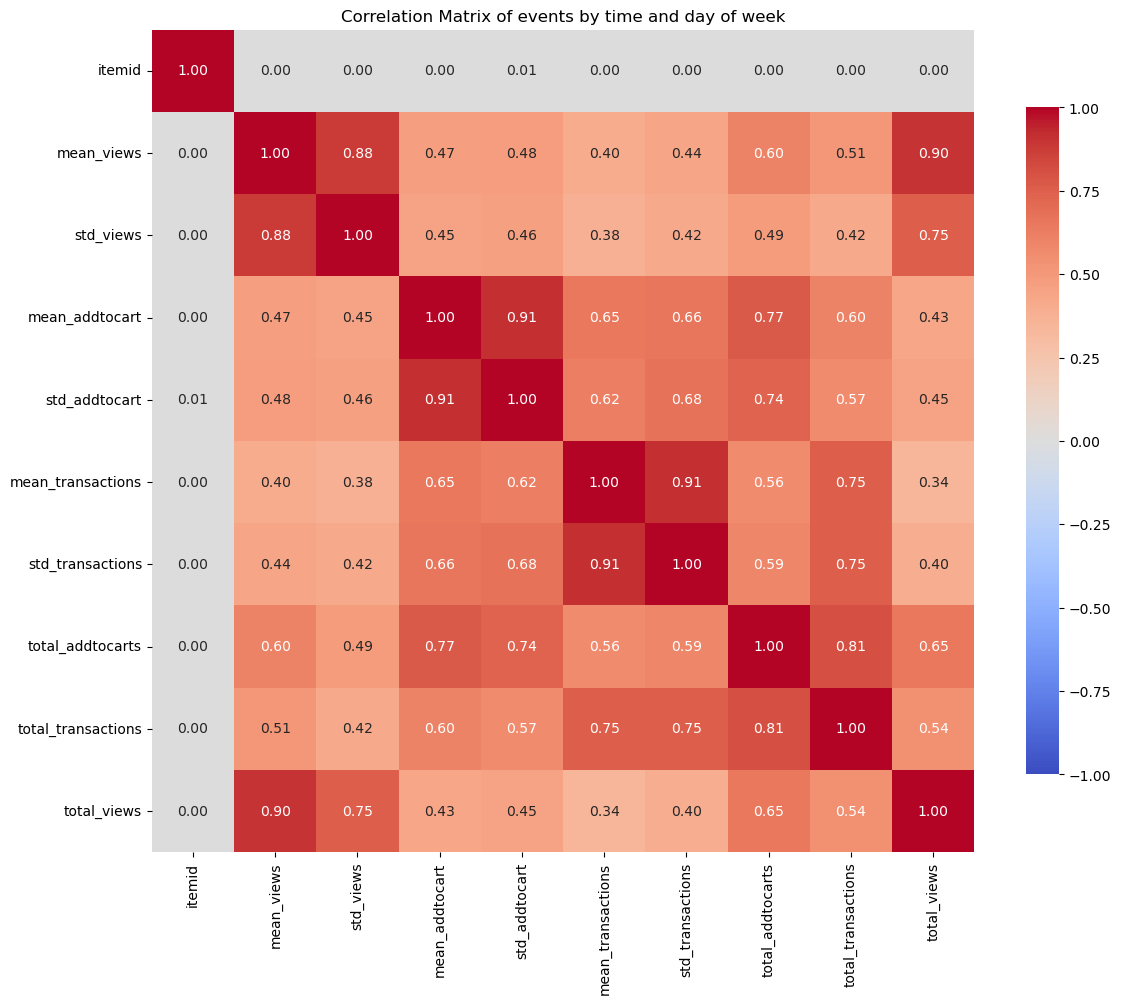

In [ ]:
# Calculate the correlation matrix 

correlation_matrix = product_summary.corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of product by event type data')
plt.tight_layout()
plt.show()

The correlation matrix shows the most closely related variables are of course, the mean and standard deviations of views, adds, and transactions and the actual values. Removing these would reduce the chances of overfitting, since otherwise they both tell about the same thing.

I'm also going to drop itemid, since it is not correlated.

In [ ]:
# drop standard deviations and means of views, adds, and transactions since they are highly correlated with the total views, adds, and transactions
product_summary = product_summary.drop(columns=['std_views', 'std_addtocart', 'std_transactions', 'mean_views', 'mean_addtocart', 'itemid', 'mean_transactions'])


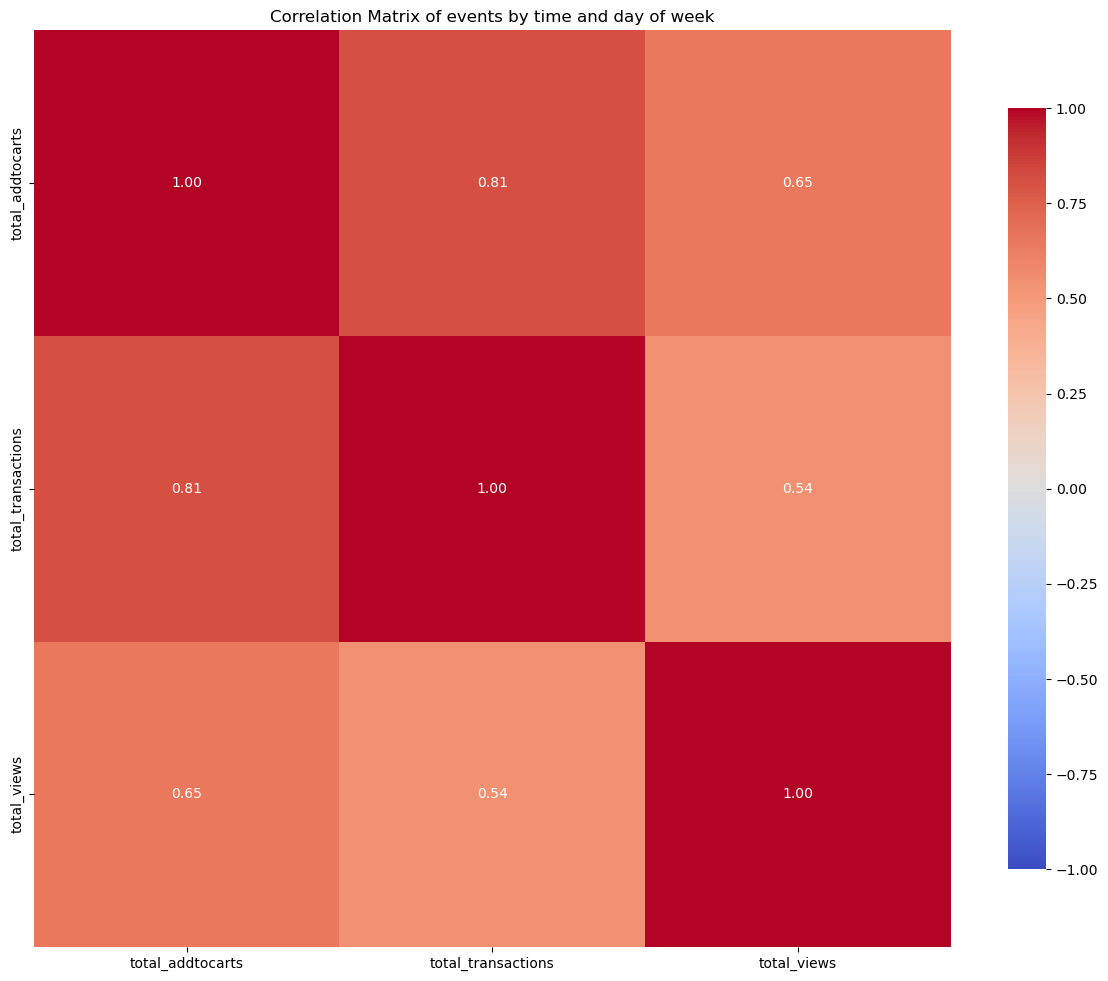

In [98]:
correlation_matrix = product_summary.corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of events by time and day of week')
plt.tight_layout()
plt.show()

This is a much better correlation matrix since it includes less redundant information. We can see that everything is positively correlated, but the addtocarts and transactions are quite highly so. Let's run the model again on this reduced number of features to compare.

In [99]:
# adding less features from product_summary

feature_cols = ['total_views', 'total_addtocarts']

subset = product_summary.dropna(subset=feature_cols + ['total_transactions'])

X = subset[feature_cols]
y = subset['total_transactions']

run_LR(X, y, feature_cols)


Regression formula: y = -0.005 + 
0.001 * total_views + 
0.319 * total_addtocarts
RMSE: 0.4
R-squared: 0.650


Interestingly, this brings the model performance down considerably. This may be because there are now not enough features to create a good model since we paired so much down. Compared to the previous model with 0.0 RMSE and 92% R², this one performs with more error (0.4 RMSE) and accounts less for variance (65% as opposed to 92%). We will keep the original model.

Previous model (all engineered features)
- Regression formula: y = -0.003 + 
0.004 * mean_views + 
-0.001 * std_views + 
0.237 * mean_addtocart + 
-0.090 * std_addtocart + 
0.353 * std_transactions + 
-0.000 * total_views + 
-0.009 * total_addtocarts + 
0.031 * total_transactions
- RMSE: 0.0
- R-squared: 0.920

#### events by timestamp and time of day
This dataframe includes the event timestamps, transaction type, time of day (coded to morning, afternoon, evening, night), and day of week (coded from 1-7 with Sunday as 1). 


In [85]:
# realized I need to one hot encode the time of day and event column to use it in linear regression

# START [ChatGPT 4.o] "right now i have a dataframe with ecommerce data have a time of day column with string values of morning, afternoon, evening, or night. how would i one hot encode these to have a column for each string with a 1 or 0 depending on the value (1 if yes, 0 if not)?"

# one hot encoding the time of day to columns of 0 and 1
event_df_encoded = pd.get_dummies(event_df_copy, columns=['time_of_day'], drop_first=False)

dummy_cols = [col for col in event_df_encoded.columns if col.startswith('time_of_day_')]
event_df_encoded[dummy_cols] = event_df_encoded[dummy_cols].astype(int)

# END [ChatGPT 4.o]

event_df_encoded.head(10)

,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2,5,0,0,0,1
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2,5,0,0,0,1
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2,5,0,0,0,1
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2,5,0,0,0,1
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2,5,0,0,0,1
5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2,5,0,0,0,1
6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2,5,0,0,0,1
7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2,5,0,0,0,1
8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2,4,0,0,0,1
9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2,5,0,0,0,1


In [86]:
# one hot encoding the event to columns of 0 and 1
event_df_encoded = pd.get_dummies(event_df_encoded, columns=['event'], drop_first=False)

dummy_cols_2 = [col for col in event_df_encoded.columns if col.startswith('event')]
event_df_encoded[dummy_cols_2] = event_df_encoded[dummy_cols_2].astype(int)

event_df_encoded.head(10)

,timestamp,visitorid,itemid,transactionid,day_of_week,hour,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night,event_addtocart,event_transaction,event_view
0,2015-06-02 05:02:12.117,257597,355908,NaN,2,5,0,0,0,1,0,0,1
1,2015-06-02 05:50:14.164,992329,248676,NaN,2,5,0,0,0,1,0,0,1
2,2015-06-02 05:13:19.827,111016,318965,NaN,2,5,0,0,0,1,0,0,1
3,2015-06-02 05:12:35.914,483717,253185,NaN,2,5,0,0,0,1,0,0,1
4,2015-06-02 05:02:17.106,951259,367447,NaN,2,5,0,0,0,1,0,0,1
5,2015-06-02 05:48:06.234,972639,22556,NaN,2,5,0,0,0,1,0,0,1
6,2015-06-02 05:12:03.240,810725,443030,NaN,2,5,0,0,0,1,0,0,1
7,2015-06-02 05:34:51.897,794181,439202,NaN,2,5,0,0,0,1,0,0,1
8,2015-06-02 04:54:59.221,824915,428805,NaN,2,4,0,0,0,1,0,0,1
9,2015-06-02 05:00:04.592,339335,82389,NaN,2,5,0,0,0,1,0,0,1


In [87]:
# adding all features from event_df_copy

feature_cols = ['day_of_week', 'hour', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night', 'event_addtocart', 'event_view']

subset = event_df_encoded.dropna(subset=feature_cols + ['event_transaction'])

X = subset[feature_cols]
y = subset['event_transaction']

run_LR(X, y, feature_cols)


Regression formula: y = 1.000 + 
-0.000 * day_of_week + 
0.000 * hour + 
-0.000 * time_of_day_afternoon + 
-0.000 * time_of_day_evening + 
0.000 * time_of_day_morning + 
0.000 * time_of_day_night + 
-1.000 * event_addtocart + 
-1.000 * event_view
RMSE: 0.0
R-squared: 1.000


This model performs better than the previous models even though it only uses the times and days of the week.
- The RMSE is 0.0, meaning there is a very low rounded down error.
- The R² is 1.00 which suggests that the correlation is perfect, and you can reliably predict transactions by time of day. This corresponds to the exploratory findings above in the feature engineering that the time of day is highly correlated to the actions, and most transactions are happening in the evening.

Values
- -0.000/0.000 - day of week, hour, or any of the timeframes is not correlated to the transactions, meaning the day of the week has no impact on the transaction amount.
- -0.001 - std views is slightly negatively correlated which means the smaller the std (the tighter the cluster), the more likely there is to be a transaction.
- -1.000 - add to cart and view are correlated negatively to the transactions, meaning as they go down transactions go up, which doesn't match with above models so may be an issue with the feature engineering.

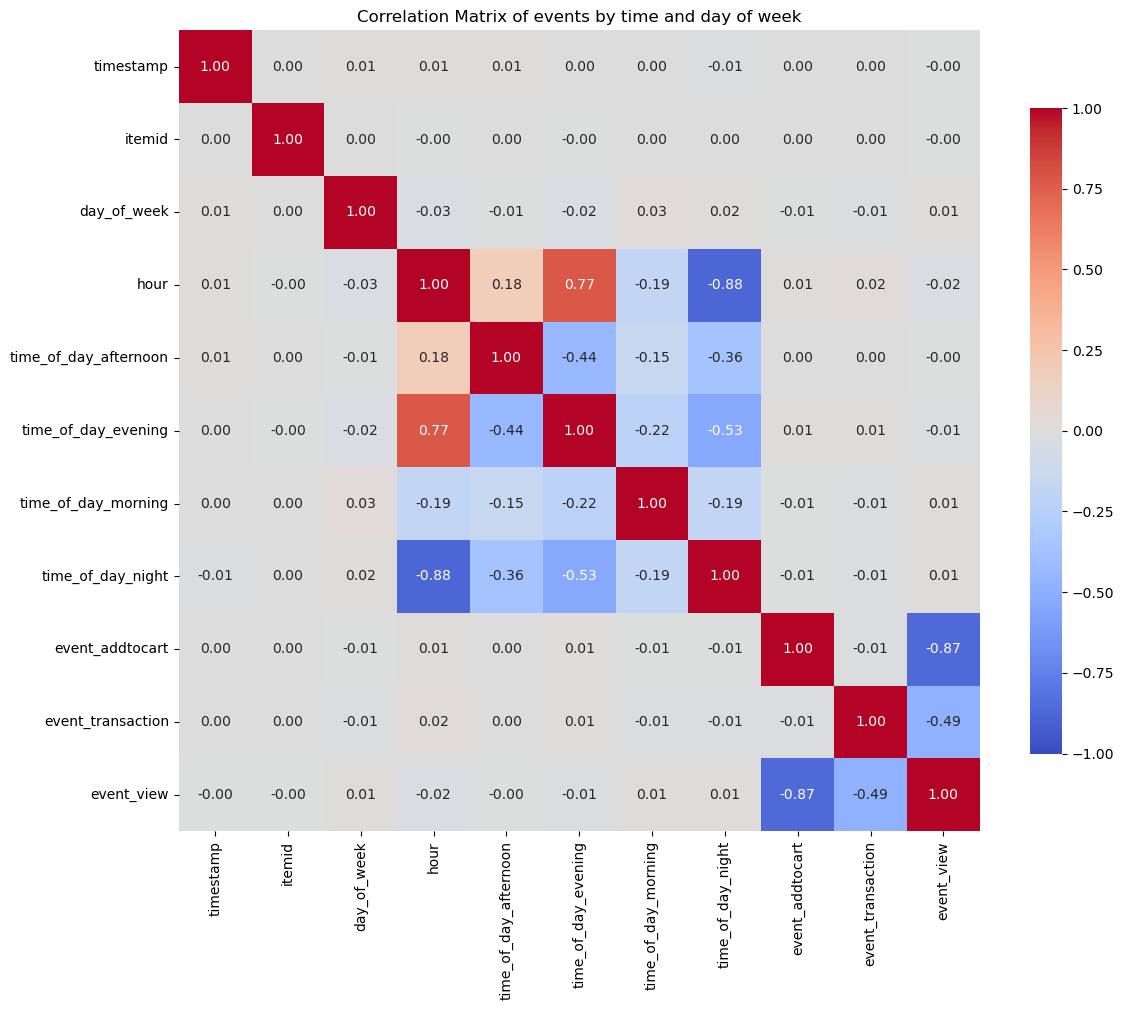

In [ ]:
# Calculate the correlation matrix 

correlation_matrix = event_df_encoded.drop(columns=['visitorid', 'transactionid']).corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of events by time and day of week')
plt.tight_layout()
plt.show()

This correlation matrix shows that most of the features are not correlated at all. I am going to drop them to reduce model bloat and potential overfitting and compare the linear regression results.

In [100]:
# drop barely correlated features

event_df_encoded_corr = event_df_encoded.drop(columns=['itemid', 'day_of_week', 'timestamp'])

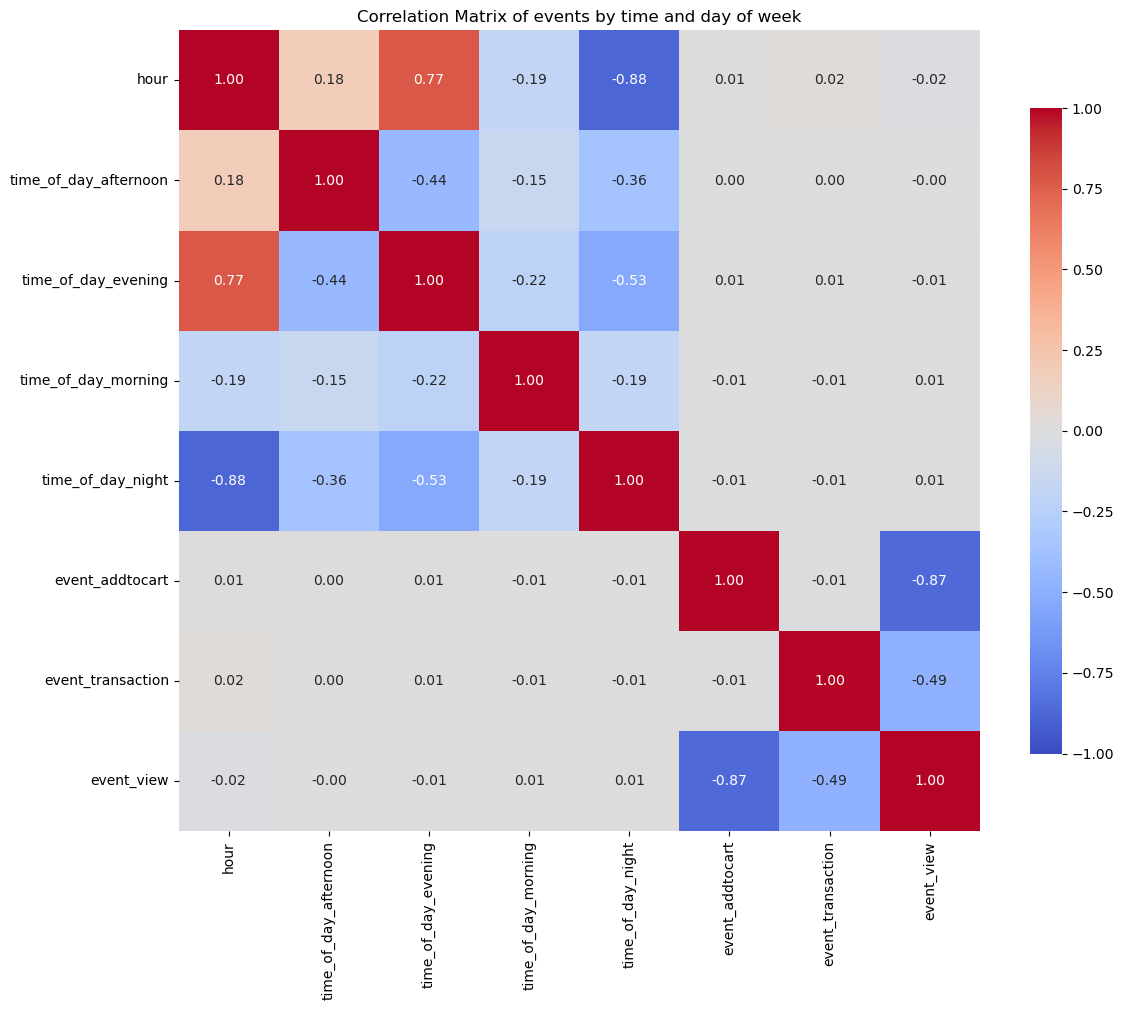

In [101]:
correlation_matrix = event_df_encoded_corr.drop(columns=['visitorid', 'transactionid']).corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of events by time and day of week')
plt.tight_layout()
plt.show()

In [102]:
feature_cols = ['hour', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night', 'event_addtocart', 'event_view']

subset = event_df_encoded_corr.dropna(subset=feature_cols + ['event_transaction'])

X = subset[feature_cols]
y = subset['event_transaction']

run_LR(X, y, feature_cols)


Regression formula: y = 1.000 + 
-0.000 * hour + 
0.000 * time_of_day_afternoon + 
0.000 * time_of_day_evening + 
0.000 * time_of_day_morning + 
0.000 * time_of_day_night + 
-1.000 * event_addtocart + 
-1.000 * event_view
RMSE: 0.0
R-squared: 1.000


The RMSE and R² result are the same, indicating that these features were not impacting the model at all, so we can keep to the previous model.

#### final model performance comparison

The goal of the analysis was to find the best predictor of the transaction amount, and we used four models to test this.

- The **baseline model** used views and addtocarts to predict the transactions and has an R² of 0.394 and RMSE of 0.1, so is not that powerful for prediction.

- The **product by transaction** model using the mean/std/actual view, addtocart, and transaction values, had the strongest relationship predicting the transactions and an RMSE of 0.0 and R² of 0.92. It predicted that addtocarts and transactions were positively correlated with p 0.81, meaning addtocarts account for 81% of transactions. This is the best overall performing model with regards to metrics and p values, so would be the one to use for future prediction.

- The **event data by timestamp** using the timeframe and day of the week data to predict transactions had strong metrics with an RMSE of 0.0 and the R² of 1, did not predict particularly strong correlations for transactions, with the strongest being a -0.49 negative correlation to views, which doesn't make sense since the more views a product has, typically the more addtocarts and transactions it has.

- The **weekly data by product** with all the actual values for events, days since last view, unique event initiators, and addtocart to transaction ratio features had an RMSE of 0.0 and R² of 0.966, and found some predictors for transactions. In this model, the unique transactors was correlated to the transactions by 0.98, which means it accounts for the transaction amount by 98%. While this seems very high, the amount of unique transactors is only something that can be gathered while transactions are happening, so is not that useful for prediction. The second highest preductor was the addtocart to transaction ratio (0.67), which again is a post-purchase metric so not that useful for prediction. The next is the unique people who added the product to the cart (0.64), which could be used for prediction only once the product was added to the cart, which is relatively late in prediction. Overall, for these reasons, this model seems less useful than the product by transaction model although it has a slightly larger R², because the individual predictors are smaller.

- The **weekly aggregate data** with the event count, mean, and standard deviation data per week, had an RMSE of 45.9 and R² of 0.941, and found some strong predictive results, like a 0.98, or 98% correlation between addtocarts and transactions, and 0.96 or 96% correlation between views and transactions. This model does have the highest predictors and R², but also has a much higher RMSE, so is more risky to use than the **product by transaction model.**

#### Overall result

The weekly aggregate data, for a riskier but potentially more predictive, or product by transaction, for a more conservative choice, are the two best performing models, so would be the ones to use for future prediction.

